In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_fourier_z = pd.read_csv(os.path.join(folder_path, "features_fourier_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_fourier_mm = pd.read_csv(os.path.join(folder_path, "features_fourier_all_minmax.csv"))

In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_z_cl= df_fourier_z.drop(columns=['filename', 'label'])

se va a buscar el que podría ser el mejor numero de clusteres usando BIC (Bayesian Information Criterion) y AIC (Akaike Information Criterion)

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

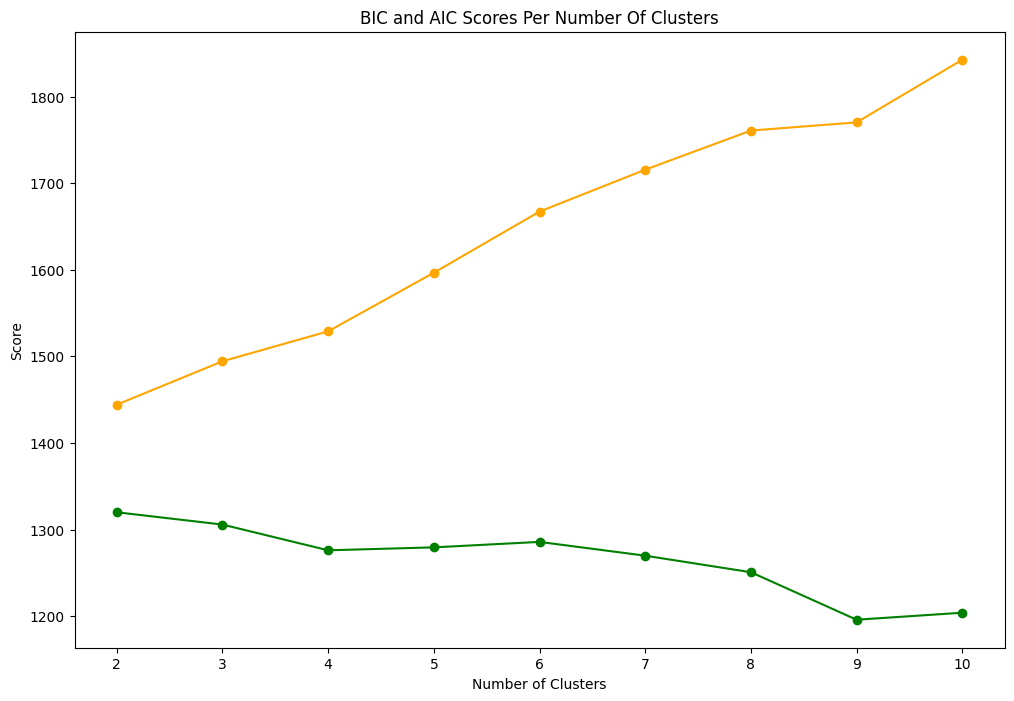

In [4]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_fourier_z_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_fourier_z_cl))
    aic_score.append(gm.aic(df_fourier_z_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')



El mejor número de clusters según AIC es probablemente 9, porque el AIC alcanza su valor mínimo allí.

El BIC, sin embargo, sugiere que el modelo con 2 clusters ya era suficientemente bueno

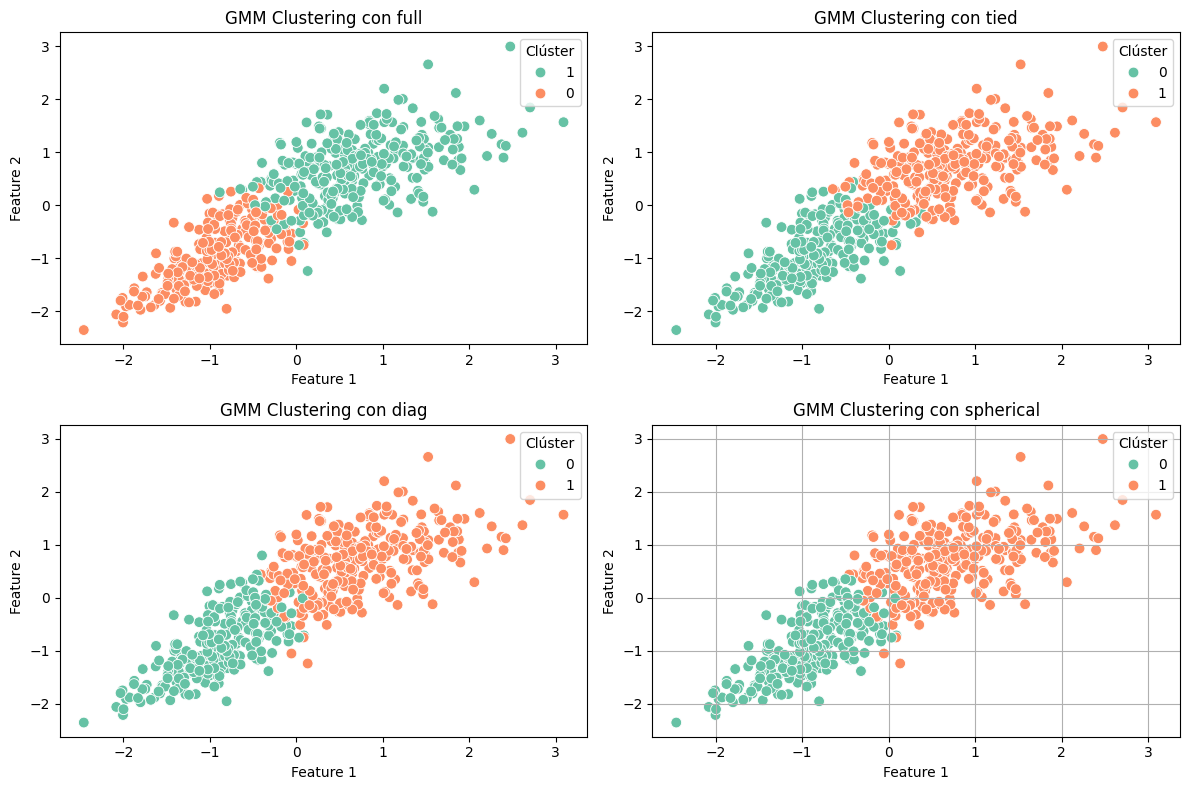

In [5]:
# GMM con distintas covarianzas
n_components = 2
covariance_types = ['full', 'tied', 'diag', 'spherical']
gmm_models_z = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
                for cov_type in covariance_types}

# Entrenar modelos
for cov_type, gmm_model in gmm_models_z.items():
    gmm_model.fit(df_fourier_z_cl)

# Predicciones
predictions_z = {cov_type: gmm_model.predict(df_fourier_z_cl)
                 for cov_type, gmm_model in gmm_models_z.items()}

# Visualización en el espacio original (2 primeras características)
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    df_plot = pd.DataFrame({
        'Feature 1': df_fourier_z_cl.iloc[:, 0],
        'Feature 2': df_fourier_z_cl.iloc[:, 1],
        'Cluster': predictions_z[cov_type].astype(str)
    })

    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=df_plot,
        x='Feature 1',
        y='Feature 2',
        hue='Cluster',
        palette='Set2',
        s=60,
        edgecolor='white',
        alpha=1
    )
    plt.title(f'GMM Clustering con {cov_type}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Clúster', loc='best')

plt.tight_layout()
plt.grid(True)
plt.show()

In [6]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_fourier_z_cl, predictions_z[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.490
Tied covariance: Silhouette Score = 0.488
Diag covariance: Silhouette Score = 0.528
Spherical covariance: Silhouette Score = 0.527


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


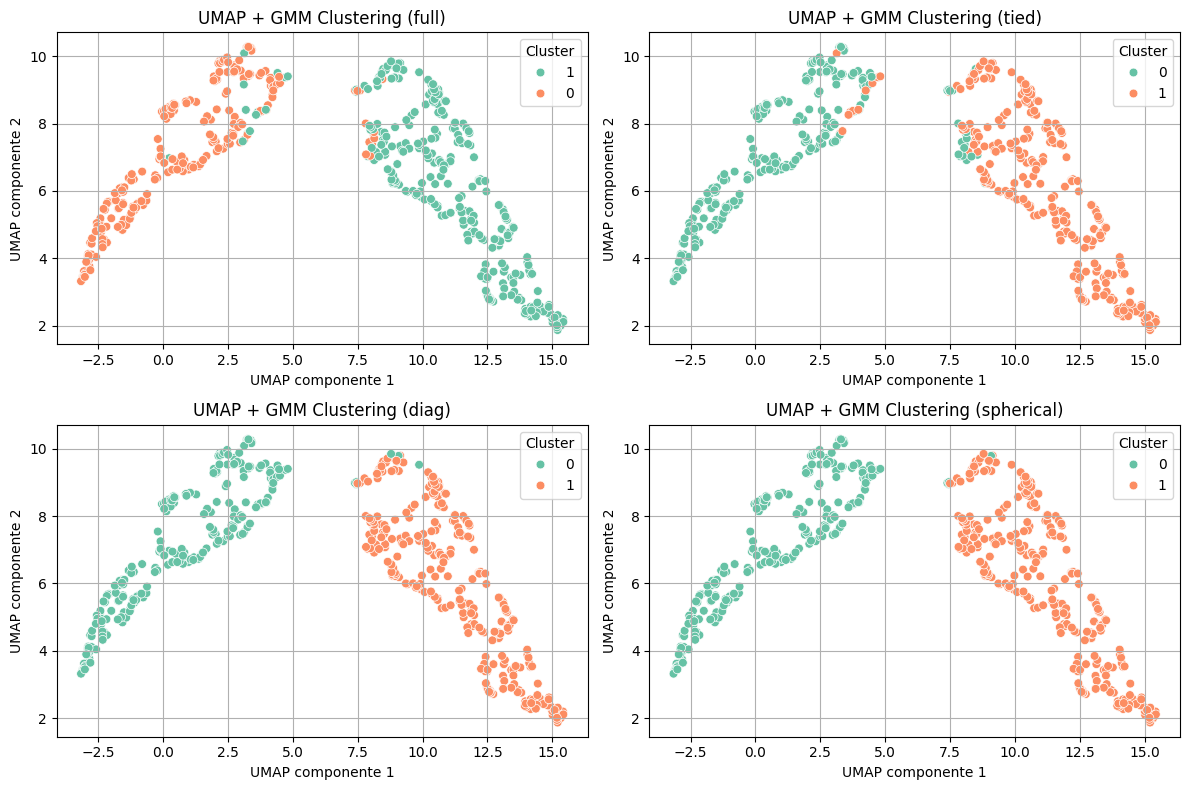

In [ ]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_fourier_z_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    
    clusters = predictions_z[cov_type]
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    
    # Mapear clusters a strings para seaborn
    df_plot = pd.DataFrame({
        'UMAP 1': embedding[:, 0],
        'UMAP 2': embedding[:, 1],
        'Cluster': clusters.astype(str)
    })
    
    # Paleta categórica con n colores
    palette = sns.color_palette("Set2", n_colors=n_clusters)
    
    sns.scatterplot(
        data=df_plot,
        x='UMAP 1',
        y='UMAP 2',
        hue='Cluster',
        palette=palette,
        edgecolor='white',
        s=40,
        alpha=1,
        legend='full'
    )
    
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP componente 1')
    plt.ylabel('UMAP componente 2')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:

df_fourier_z['predictions_z_full'] = predictions_z['full']
df_fourier_z['predictions_z_tied'] = predictions_z['tied']
df_fourier_z['predictions_z_diag'] = predictions_z['diag']
df_fourier_z['predictions_z_spherical'] = predictions_z['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_fourier_z['label'], df_fourier_z['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_fourier_z['label'], df_fourier_z['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_fourier_z['label'], df_fourier_z['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_fourier_z['label'], df_fourier_z['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)    0    1
Label                   
higher           20  248
smaller         209   60

Contingency Table for Tied Covariance:
Cluster (tied)    0    1
Label                   
higher           20  248
smaller         220   49

Contingency Table for Diagonal Covariance:
Cluster (diag)    0    1
Label                   
higher           31  237
smaller         208   61

Contingency Table for Spherical Covariance:
Cluster (spherical)    0    1
Label                        
higher                29  239
smaller              208   61


minmax

In [9]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_mm_cl= df_fourier_mm.drop(columns=['filename', 'label'])

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

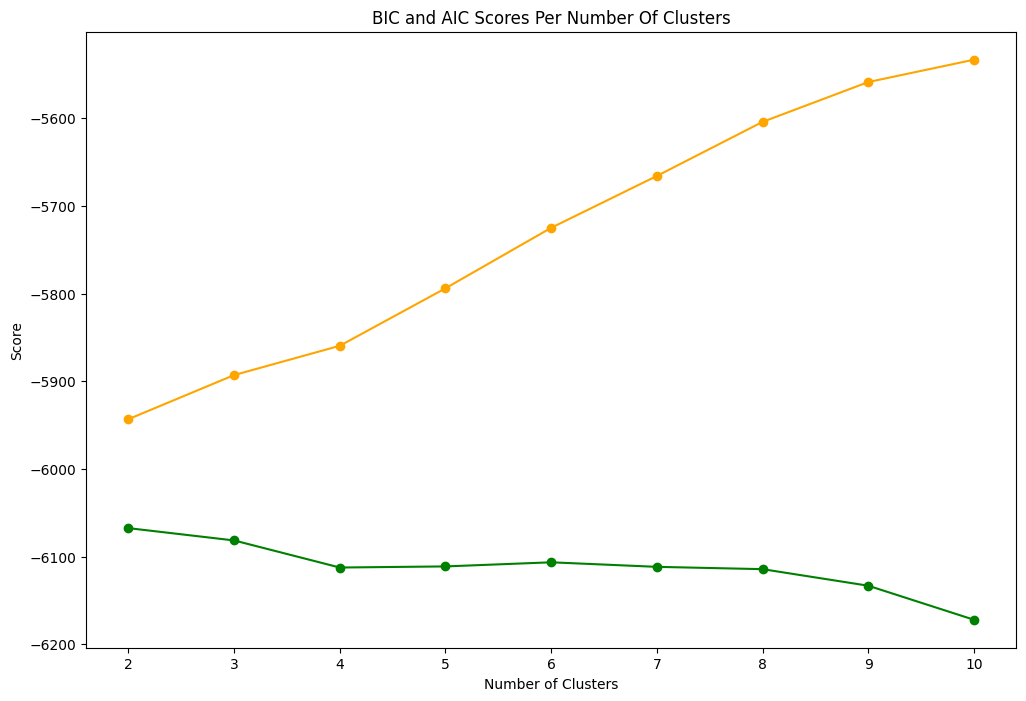

In [10]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_fourier_mm_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_fourier_mm_cl))
    aic_score.append(gm.aic(df_fourier_mm_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

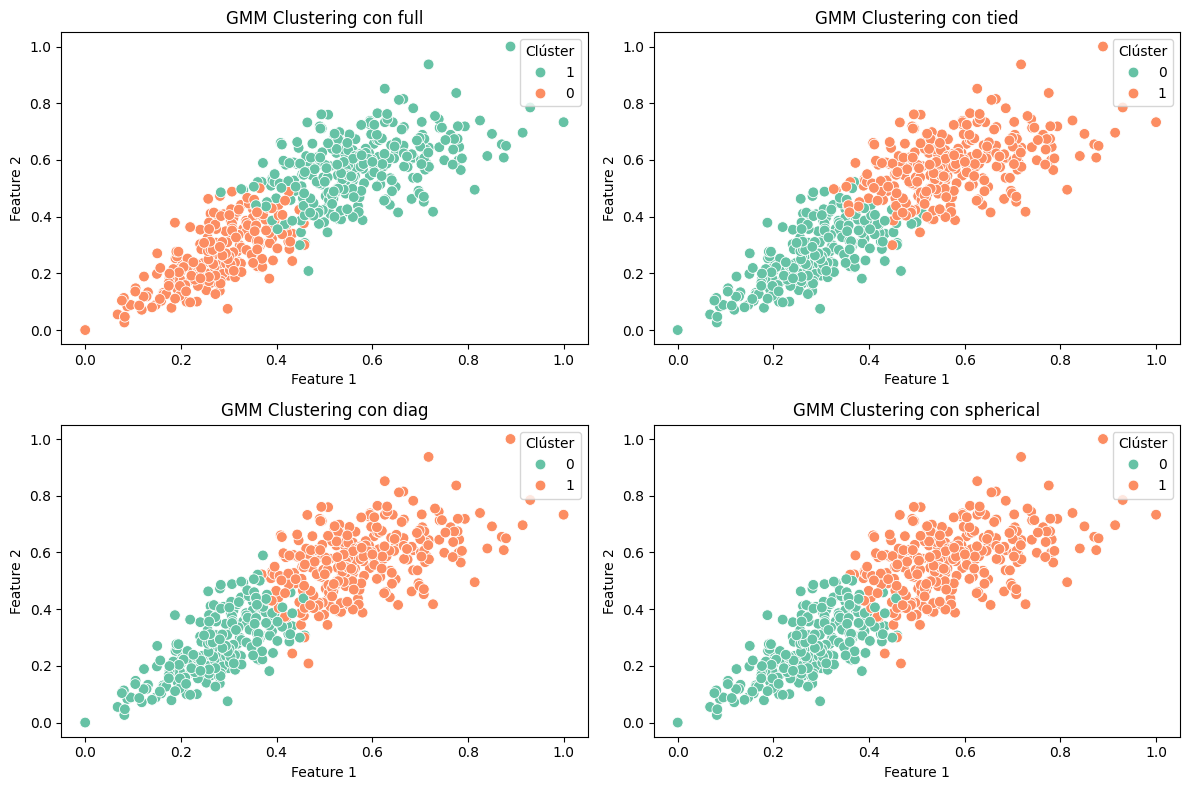

In [18]:
# Definición de parámetros
n_components = 2
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Entrenar modelos GMM
gmm_models_mm = {
    cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
    for cov_type in covariance_types
}
for cov_type, gmm in gmm_models_mm.items():
    gmm.fit(df_fourier_mm_cl)

# Obtener predicciones
predictions_mm = {
    cov_type: gmm.predict(df_fourier_mm_cl)
    for cov_type, gmm in gmm_models_mm.items()
}

# Visualización en el espacio original
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    df_plot = pd.DataFrame({
        'Feature 1': df_fourier_mm_cl.iloc[:, 0],
        'Feature 2': df_fourier_mm_cl.iloc[:, 1],
        'Cluster': predictions_mm[cov_type].astype(str)
    })

    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=df_plot,
        x='Feature 1',
        y='Feature 2',
        hue='Cluster',
        palette='Set2',
        s=60,
        edgecolor='white',
        alpha=1
    )
    plt.title(f'GMM Clustering con {cov_type}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Clúster', loc='best')

plt.tight_layout()
plt.show()

In [19]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_fourier_mm_cl, predictions_mm[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.490
Tied covariance: Silhouette Score = 0.490
Diag covariance: Silhouette Score = 0.527
Spherical covariance: Silhouette Score = 0.527


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


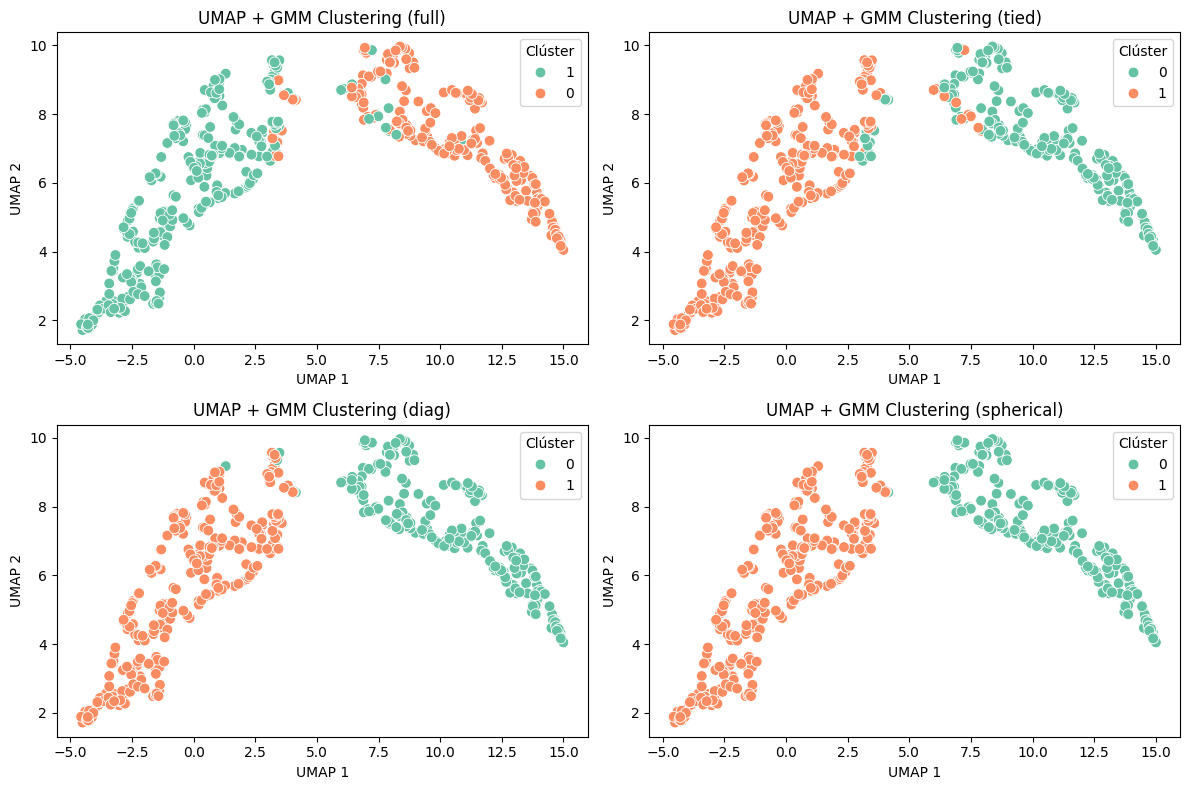

In [20]:
# Reducir dimensionalidad con UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_fourier_mm_cl)

# Visualización en espacio UMAP
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    df_umap = pd.DataFrame({
        'UMAP 1': embedding[:, 0],
        'UMAP 2': embedding[:, 1],
        'Cluster': predictions_mm[cov_type].astype(str)
    })

    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=df_umap,
        x='UMAP 1',
        y='UMAP 2',
        hue='Cluster',
        palette='Set2',
        s=60,
        edgecolor='white',
        alpha=1
    )
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Clúster', loc='best')

plt.tight_layout()
plt.show()



In [17]:

df_fourier_mm['predictions_z_full'] = predictions_mm['full']
df_fourier_mm['predictions_z_tied'] = predictions_mm['tied']
df_fourier_mm['predictions_z_diag'] = predictions_mm['diag']
df_fourier_mm['predictions_z_spherical'] = predictions_mm['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_fourier_mm['label'], df_fourier_mm['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_fourier_mm['label'], df_fourier_mm['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_fourier_mm['label'], df_fourier_mm['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_fourier_mm['label'], df_fourier_mm['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)    0    1
Label                   
higher          247   21
smaller          60  209

Contingency Table for Tied Covariance:
Cluster (tied)    0    1
Label                   
higher          248   20
smaller          49  220

Contingency Table for Diagonal Covariance:
Cluster (diag)    0    1
Label                   
higher          237   31
smaller          61  208

Contingency Table for Spherical Covariance:
Cluster (spherical)    0    1
Label                        
higher                27  241
smaller              207   62


Tanto con la normalización z-score como min-max salen resultados esperables y parecidos al resto